In [ ]:
# default_exp USB_camera

%load_ext autoreload
%autoreload 2

# FLIR_video_stream
> API details.
- [c++ prgrammers guide - local](file:///usr/share/doc/spinnaker-doc/C-Plus-Plus-ProgrammerGuide.html)
- [Software guide C++](http://softwareservices.ptgrey.com/Spinnaker/latest/index.html)
- [Technical notes](https://www.flir.com/support/products/blackfly-s-usb3#Overview)
- [spinnaker-nodes](https://www.flir.com/support-center/iis/machine-vision/application-note/spinnaker-nodes/)
- [understanding-buffer-handling](https://www.flir.com/support-center/iis/machine-vision/application-note/understanding-buffer-handling/)
- [A Pythonic class-based wrapper for the FLIR PySpin Library](https://github.com/klecknerlab/simple_pyspin)

In [ ]:
#hide
from nbdev.showdoc import *
from nbdev.imports import test_eq

In [ ]:
#export
from  FLIRCam.core import *

In [ ]:
#export
# Standard imports:
from pathlib import Path
import logging
from logging.handlers import RotatingFileHandler
from time import sleep, time as timestamp
from datetime import datetime
from threading import Thread, Event
from struct import pack as pack_data

# External imports:
import numpy as np

In [ ]:
#export
import PySpin
class Camera():
    """Control acquisition and receive images from a camera.
    To initialise a Camera a *model* (determines hardware interface) and *identity* (identifying the specific device)
    must be given. If both are given to the constructor the Camera will be initialised immediately (unless
    auto_init=False is passed). Manually initialise with a call to Camera.initialize(); release hardware with a call to
    Camera.deinitialize().
    After the Camera is intialised, acquisition properties (e.g. exposure_time and frame_rate) may be set and images
    received. The Camera also supports event-driven acquisition, see Camera.add_event_callback(), where new images are
    automatically passed on to the desired functions.
    Args:
        model (str, optional): The model used to determine the correct hardware API. Supported: 'ptgrey' for
            PointGrey/FLIR Machine Vision cameras (using Spinnaker and PySpin).
        identity (str, optional): String identifying the device. For model *ptgrey* this is 'serial number' *as a
            string*.
        name (str, optional): Name for the device.
        auto_init (bool, optional): If both model and identity are given when creating the Camera and auto_init
            is True (the default), Camera.initialize() will be called after creation.
        debug_folder (pathlib.Path, optional): The folder for debug logging. If None (the default)
            the folder *pypogs*/debug will be used/created.
    Example:
        ::
            # Create instance and set parameters (will auto initialise)
            cam = pypogs.Camera(model='ptgrey', identity='18285284', name='CoarseCam')
            cam.gain = 0 #decibel
            cam.exposure_time = 100 #milliseconds
            cam.frame_rate_auto = True
            # Start acquisition
            cam.start()
            # Wait for a while
            time.sleep(2)
            # Read the latest image
            img = cam.get_latest_image()
            # Stop the acquisition
            cam.stop()
            # Release the hardware
            cam.deinitialize()
    """
    _supported_models = ('ptgrey',)

    def __init__(self, model=None, identity=None, name=None, auto_init=True, debug_folder=None):
        """Create Camera instance. See class documentation."""
        # Logger setup
        self._debug_folder = None
        if debug_folder is None:
            try:
                self.debug_folder = Path(__file__).parent / 'debug'
            except:
                self.debug_folder = Path()/'debug'
        else:
            self.debug_folder = debug_folder
        self.log = logging.getLogger(f'{name}')
        if not self.log.hasHandlers():
            # Add new handlers to the logger if there are none
            self.log.setLevel(logging.DEBUG)
            # Console handler at INFO level
            ch = logging.StreamHandler()
            ch.setLevel(logging.INFO)
            # File handler at DEBUG level
            # fh = logging.FileHandler(self.debug_folder / 'log.txt')
            fh = RotatingFileHandler(self.debug_folder / 'camera.log', maxBytes=1*1024*1024,
                                 backupCount=2)
            fh.setLevel(logging.DEBUG)
            # Format and add
            # log_formatter = logging.Formatter('%(asctime)s:%(name)s-%(levelname)s: %(message)s')
            # log_formatter = logging.Formatter('%(asctime)s CAM-%(levelname)s: %(message)s')
            log_formatter = logging.Formatter('%(asctime)s %(name)s-%(levelname)s-%(threadName)s'+
                                              '-%(funcName)s-(%(lineno)d) %(message)s')

            fh.setFormatter(log_formatter)
            ch.setFormatter(log_formatter)
            self.log.addHandler(fh)
            self.log.addHandler(ch)
            self.log.info('New  console and file logging handlers added.')    

        # Start of constructor
        self.log.debug('Camera Init: Model:'+str(model)+' ID:'+str(identity) \
                           +' Name:'+str(name) +' AutoInit:'+str(auto_init))
        self._model = None
        self._identity = None
        self._name = 'UnnamedCamera'
        self._plate_scale = 1.0
        self._rotation = 0.0
        self._flipX = False
        self._flipY = False
        self._rot90 = 0 #Number of times to rotate by 90 deg, done after flips
        #Only used for ptgrey
        self._ptgrey_camera = None
        self._ptgrey_camlist = None
        self._ptgrey_system = None
        #Callbacks on image event
        self._call_on_image = set()
        self._got_image_event = Event()
        self._image_data = None
        self._image_frameID = None
        self._image_timestamp = None
        self._imgs_since_start = 0

        self.log.debug('Calling self on constructor input')
        if model is not None:
            self.model = model
        if identity is not None:
            self.identity = identity
        if name is not None:
            self.name = name
        if auto_init and not None in (model, identity):
            self.log.debug('Trying to auto-initialise')
            self.initialize()
        self.log.debug('Registering destructor')
        # TODO: Should we register deinitialisor instead? (probably yes...)
        import atexit, weakref
        atexit.register(weakref.ref(self.__del__))
        self.log.info('Camera instance created with name: ' + self.name + '.')

    def __del__(self):
        """Destructor. Releases hardware."""
        if self.is_init:
            self.deinitialize()
    def getprops(self, prop_list):
        """ Get FLIR Camera properties, listed in the prop_list"""
        assert self.is_init, 'Camera must be initialised'
        
        prop_dict = { i : None for i in prop_list }
        
        try:
            nodemap = self._ptgrey_camera.GetNodeMap()  
            for i, p in enumerate(prop_list):
                # val_list[i] = PySpin.CIntegerPtr(nodemap.GetNode(p)).GetValue()
                try:  # integer
                    prop_dict[p] = PySpin.CIntegerPtr(nodemap.GetNode(p)).GetValue()
                except: 
                    try: # Float
                        prop_dict[p] = PySpin.CFloatPtr(nodemap.GetNode(p)).GetValue()
                    except: 
                        try: # enumeration
                            node = PySpin.CEnumerationPtr(nodemap.GetNode(p))
                            prop_dict[p] = node.GetCurrentEntry().GetDisplayName().lower()
                        except: # Bool                           
                            prop_dict[p] = PySpin.CBooleanPtr(nodemap.GetNode(p)).GetValue()
                            
                self.log.debug(f'Found Node "{str(p)}" = {prop_dict[p]}')

        except PySpin.SpinnakerException:
            self.log.warning(f'Failed to read node "{str(p)}"')
        finally:
            return prop_dict

    def setprops(self, prop_dict, stop=True):
        """ Set FLIR Camera properties, listed in the prop_dict"""
        assert self.is_init, 'Camera must be initialised'
        was_stopped = False
        if self.is_running and stop:
            self.log.debug('Camera is running, stop it and restart immediately after.')
            self.stop()
            was_stopped = True
        assert self.is_init, 'Camera must be initialised'
        
        type_list = [type(value) for key, value in self.getprops(prop_dict).items()]
        self.log.debug(f'Type_list = {type_list}')
        try:        

            nodemap = self._ptgrey_camera.GetNodeMap()  
            for (key, value), t in zip(prop_dict.items(), type_list):
                if t == int : # integer
                    PySpin.CIntegerPtr(nodemap.GetNode(key)).SetValue(value)            
                elif t == float: 
                    PySpin.CFloatPtr(nodemap.GetNode(key)).SetValue(value)
                elif t == str:
                    node = PySpin.CEnumerationPtr(nodemap.GetNode(key))
                    node.SetIntValue(node.GetEntryByName(value).GetValue())
                elif t == bool:
                    # node = PySpin.CBooleanPtr(nodemap.GetNode('AcquisitionFrameRateEnable'))
                    PySpin.CBooleanPtr(nodemap.GetNode(key)).SetValue(value)
                elif t == type(None):
                    self.log.warning(f'No property type found for node: "{key}"')
                    # raise Exception(f'No property type found for node: "{key}"')
                    return
                else:
                    self.log.warning(f'Property type not implemented for node: "{key}"')
                    # raise Exception(f'Property type not implemented for node: "{key}"')
                    return
    
                self.log.debug(f'Set Node "{key}" = {value}')
        
        except PySpin.SpinnakerException as e:
            if 'LogicalErrorException' in e.message:
                self.log.warning(f'Node: "{key}",  LogicalErrorException')
            elif 'OutOfRangeException' in e.message:
                self.log.warning(f'Node: "{key}",  value: "{value}" is out of range.')
            elif 'AccessException' in e.message:
                self.log.warning(f'Not allowed to change Node: "{key}" now - Try "stop=True".')
            else:
                self.log.warning(f'Failed to set node: "{key}"')
                
        if was_stopped :
            try:
                self.start()
                self.log.debug('Restarted')
            except Exception:
                self.log.debug('Failed to restart: ', exc_info=True)

    def _ptgrey_release(self):
        """PRIVATE: Release Point Grey hardware resources."""
        self.log.debug('PointGrey hardware release called')
        if self._ptgrey_camera is not None:
            self.log.debug('Deleting PtGrey camera object')
            del(self._ptgrey_camera) #Preferred over =None according to PtGrey
            self._ptgrey_camera = None
        if self._ptgrey_camlist is not None:
            self.log.debug('Clearing and deleting PtGrey camlist')
            self._ptgrey_camlist.Clear()
            del(self._ptgrey_camlist)
            self._ptgrey_camlist = None
        if self._ptgrey_system is not None:
            self.log.debug('Has PtGrey system. Is in use? '+str(self._ptgrey_system.IsInUse()))
            if not self._ptgrey_system.IsInUse():
                self.log.debug('Not in use, releasing and deleting')
                self._ptgrey_system.ReleaseInstance()
                del(self._ptgrey_system)
                self._ptgrey_system = None
        self.log.debug('Hardware released')

    @property
    def debug_folder(self):
        """pathlib.Path: Get or set the path for debug logging. Will create folder if not existing."""
        return self._debug_folder
    @debug_folder.setter
    def debug_folder(self, path):
        # Do not do logging in here! This will be called before the logger is set up
        path = Path(path) #Make sure pathlib.Path
        if path.is_file():
            path = path.parent
        if not path.is_dir():
            path.mkdir(parents=True)
        self._debug_folder = path

    @property
    def name(self):
        """str: Get or set the name."""
        return self._name
    @name.setter
    def name(self, name):
        self.log.debug('Setting name to: '+str(name))
        self._name = str(name)
        self.log.debug('Name set to '+str(self.name))

    @property
    def model(self):
        """str: Get or set the device model.
        Supported:
            - 'ptgrey' for FLIR/Point Grey cameras (using Spinnaker/PySpin SDKs).
        - This will determine which hardware API that is used.
        - Must set before initialising the device and may not be changed for an initialised device.
        """
        return self._model
    @model.setter
    def model(self, model):
        self.log.debug('Setting model to: '+str(model))
        assert not self.is_init, 'Can not change already intialised device model'
        model = str(model)
        assert model.lower() in self._supported_models,\
                                                'Model type not recognised, allowed: '+str(self._supported_models)
        #TODO: Check that the APIs are available.
        self._model = model
        self.log.debug('Model set to '+str(self.model))

    @property
    def identity(self):
        """str: Get or set the device and/or input. Model must be defined first.
        - For model *ptgrey* this is the serial number *as a string*
        - Must set before initialising the device and may not be changed for an initialised device.
        """
        return self._identity
    @identity.setter
    def identity(self, identity):
        self.log.debug('Setting identity to: '+str(identity))
        assert not self.is_init, 'Can not change already intialised device'
        assert self.model is not None, 'Must define model first'
        identity = str(identity)
        if not self._ptgrey_system:
            self._ptgrey_system = PySpin.System.GetInstance() #Get singleton
        self._ptgrey_camlist = self._ptgrey_system.GetCameras()
        self.log.debug('Got cam list, size:'+str(self._ptgrey_camlist.GetSize()))
        self._ptgrey_camera = self._ptgrey_camlist.GetBySerial(identity)
        valid = self._ptgrey_camera.IsValid()
        self.log.debug('Got object, valid: '+str(valid))
        if valid:
            self.log.debug('Already init: '+str(self._ptgrey_camera.IsInitialized()))
        if not valid:
            self.log.debug('Invalid camera object. Cleaning up')
            del(self._ptgrey_camera)
            self._ptgrey_camera = None
            self._ptgrey_camlist.Clear()
            raise AssertionError('The camera was not found')
        elif self._ptgrey_camera.IsInitialized():
            self.log.debug('Camera object already in use. Cleaning up')
            del(self._ptgrey_camera)
            self._ptgrey_camera = None
            self._ptgrey_camlist.Clear()
            raise RuntimeError('The camera is already in use')
        else:
            self.log.debug('Seems valid. Setting identity and cleaning up')
            del(self._ptgrey_camera)
            self._ptgrey_camera = None
            self._identity = identity
            self._ptgrey_camlist.Clear()
        self.log.debug('Identity set to: '+str(self.identity))

    @property
    def is_init(self):
        """bool: True if the device is initialised (and therefore ready to start)."""
        init = self._ptgrey_camera is not None and self._ptgrey_camera.IsInitialized()
        return init

    def initialize(self):
        """Initialise (make ready to start) the device. The model and identity must be defined."""
        self.log.debug('Initialising')
        assert not self.is_init, 'Already initialised'
        assert not None in (self.model, self.identity), 'Must define model and identity before initialising'

        if self._ptgrey_camera is not None:
            raise RuntimeError('There is already a camera object here')
        
        if not self._ptgrey_system: self._ptgrey_system = PySpin.System.GetInstance() #Get singleton
        if self._ptgrey_camlist: #Clear old list and get fresh one
            self._ptgrey_camlist.Clear()
            del(self._ptgrey_camlist)
        self._ptgrey_camlist = self._ptgrey_system.GetCameras()
        self.log.debug('Getting pyspin object and initialising')
        self._ptgrey_camera = self._ptgrey_camlist.GetBySerial(self.identity)
        self._ptgrey_camera.Init()
        
        # BASIC SETUP          
        # self.log.debug('Setting gamma off')
        # nodemap = self._ptgrey_camera.GetNodeMap()
        # PySpin.CBooleanPtr(nodemap.GetNode('GammaEnable')).SetValue(False)
        
        self.log.debug('Setting acquisition mode to continuous')
        self._ptgrey_camera.AcquisitionMode.SetIntValue(PySpin.AcquisitionMode_Continuous)
        self.log.debug('Setting stream mode to newest only')
        self._ptgrey_camera.TLStream.StreamBufferHandlingMode.SetIntValue(
                                                                    PySpin.StreamBufferHandlingMode_NewestOnly)
        self.log.info('Camera successfully initialised')
        
    def deinitialize(self):
        """De-initialise the device and release hardware resources. Will stop the acquisition if it is running."""
        self.log.debug('De-initialising')
        assert self.is_init, 'Not initialised'
        if self.is_running:
            self.log.debug('Is running, stopping')
            self.stop()
            self.log.debug('Stopped')

        self.log.debug('Found PtGrey camera, deinitialising')
        self.unregister_event_handler()
        try:
            self._ptgrey_camera.DeInit()
            del(self._ptgrey_camera)
            self._ptgrey_camera = None
            self.log.debug('Deinitialised PtGrey camera object and deleted')
        except:
            self.log.exception('Failed to close task')
        self.log.debug('Trying to release PtGrey hardware resources')
        self._ptgrey_release()

    def register_event_handler(self):
        """Initialise images event handler mode."""

        class PtGreyEventHandler(PySpin.ImageEvent):
            """Barebones event handler for ptgrey, just pass along the event to the Camera class."""
            def __init__(self, parent):
                assert parent.model.lower() == 'ptgrey', 'Trying to attach ptgrey event handler to non ptgrey model'
                super().__init__()
                self.parent = parent

            def OnImageEvent(self, image:PySpin.Image):
                """Read out the image and a timestamp, reshape to array, pass to parent"""
                # self.parent.log.debug('Image event! Unpack and release pointer')
                self.parent._image_timestamp = datetime.utcnow()
                try:
                    # img = image.GetData()
                    image_converted = image.Convert(PySpin.PixelFormat_RGB8)
                    image_converted = image_converted.GetNDArray()
                    # print('img', image_converted.shape)
                    # img = img.reshape((img_ptr.GetHeight(), img_ptr.GetWidth(), 3))
                    if self.parent._flipX:
                        img = np.fliplr(image_converted)
                    if self.parent._flipY:
                        img = np.flipud(image_converted)
                    if self.parent._rot90:
                        img = np.rot90(image_converted, self.parent._rot90)
                    self.parent._image_data = image_converted
                    self.parent._image_frameID = image.GetFrameID()
                except:
                    self.parent.log.warning('Failed to unpack image', exc_info=True)
                    self.parent._image_data = None
                finally:
                    image.Release()
                self.parent._got_image_event.set()
                if self.parent._imgs_since_start % 10 == 0:
                    self.parent.log.debug('Frames Received: ' + str(self.parent._imgs_since_start) \
                                           + ' Size:' + str(self.parent._image_data.shape) \
                                           + ' Type:' + str(self.parent._image_data.dtype))
                    
                for func in self.parent._call_on_image:
                    try:
                        self.parent.log.debug('Calling back to: ' + str(func))
                        func(self.parent._image_data, self.parent._image_frameID, self.parent._image_timestamp, self.parent.identity)
                    except:
                        self.parent.log.warning('Failed image callback', exc_info=True)
                self.parent._imgs_since_start += 1
                # self.parent.log.debug('Event handler finished.')

        self._ptgrey_event_handler = PtGreyEventHandler(self)
        self.log.debug('Created ptgrey image event handler')
        self._ptgrey_camera.RegisterEvent( self._ptgrey_event_handler )
        self.log.debug('Registered ptgrey image event handler')

    def unregister_event_handler(self):
        """Unregister images event handler."""
        try:
            self._ptgrey_camera.UnregisterEvent(self._ptgrey_event_handler)
            self.log.debug('Unregistered event handler')
        except:
            self.log.exception('Failed to unregister event handler')


    @property
    def available_properties(self):
        """tuple of str: Get all the available properties (settings) supported by this device."""
        assert self.is_init, 'Camera must be initialised'
        return ('flip_x', 'flip_y', 'rotate_90', 'plate_scale', 'rotation', 'binning', 'size_readout', 'frame_rate_auto',\
                'frame_rate', 'gain_auto', 'gain', 'exposure_time_auto', 'exposure_time')


    @property
    def flip_x(self):
        """bool: Get or set if the image X-axis should be flipped. Default is False."""
        self.log.debug('Get flip-X called')
        assert self.is_init, 'Camera must be initialised'
        self.log.debug('Using PtGrey camera. Will flip the received image array ourselves: ' +str(self._flipX))
        return self._flipX
    @flip_x.setter
    def flip_x(self, flip):
        self.log.debug('Set flip-X called with: '+str(flip))
        assert self.is_init, 'Camera must be initialised'
        flip = bool(flip)
        self.log.debug('Using PtGrey camera. Will flip the received image array ourselves.')
        self._flipX = flip
        self.log.debug('_flipX set to: '+str(self._flipX))

    @property
    def flip_y(self):
        """bool: Get or set if the image Y-axis should be flipped. Default is False."""
        self.log.debug('Get flip-Y called')
        assert self.is_init, 'Camera must be initialised'
        self.log.debug('Using PtGrey camera. Will flip the received image array ourselves: ' +str(self._flipX))
        return self._flipY
    @flip_y.setter
    def flip_y(self, flip):
        self.log.debug('Set flip-Y called with: '+str(flip))
        assert self.is_init, 'Camera must be initialised'
        flip = bool(flip)
        self.log.debug('Using PtGrey camera. Will flip the received image array ourselves.')
        self._flipY = flip
        self.log.debug('_flipY set to: '+str(self._flipY))

    @property
    def rotate_90(self):
        """int: Get or set how many times the image should be rotated by 90 degrees. Applied *after* flip_x and flip_y.
        """
        assert self.is_init, 'Camera must be initialised'
        return self._rot90
    @rotate_90.setter
    def rotate_90(self, k):
        self.log.debug('Set rot90 called with: '+str(k))
        assert self.is_init, 'Camera must be initialised'
        k = int(k)
        self.log.debug('Using PtGrey camera. Will rotate the received image array ourselves.')
        self._rot90 = k
        self.log.debug('rot90 set to: '+str(self._rot90))

    @property
    def plate_scale(self):
        """float: Get or set the plate scale of the Camera in arcsec per pixel.
        This will not affect anything in this class but is used elsewhere. Set this to the physical pixel plate scale
        *before* any binning. When getting the plate scale it will be scaled by the binning factor.
        """
        return self._plate_scale * self.binning
    @plate_scale.setter
    def plate_scale(self, arcsec):
        self.log.debug('Set plate scale called with: '+str(arcsec))
        self._plate_scale = float(arcsec)
        self.log.debug('Plate scale set to: '+str(self.plate_scale))

    @property
    def rotation(self):
        """float: Get or set the camera rotation relative to the horizon in degrees.
        This does not affect the received images, but is used elsewhere. Use rotate_90 first to keep this rotation
        small.
        """
        return self._rotation
    @rotation.setter
    def rotation(self, rot):
        self.log.debug('Set rotation called with: '+str(rot))
        self._rotation = float(rot)
        self.log.debug('Rotation set to: '+str(self.rotation))

    @property
    def frame_rate_auto(self):
        """bool: Get or set automatic frame rate. If True camera will run as fast as possible."""
        self.log.debug('Get frame rate auto called')
        val = self.getprops(['AcquisitionFrameRateEnable'])['AcquisitionFrameRateEnable']  
        return not val    
    @frame_rate_auto.setter
    def frame_rate_auto(self, auto):
        self.log.debug('Set frame rate called with: '+str(auto))
        auto = bool(auto)
        self.setprops({'AcquisitionFrameRateEnable': not auto})

    @property
    def frame_rate_limit(self):
        """tuple of float: Get the minimum and maximum frame rate in Hz supported."""
        self.log.debug('Get frame rate limit called')
        mn,mx = list(self.getprops(['FrameRateHz_Min', 'FrameRateHz_Max']).values())
        return (mn,mx)

    @property
    def frame_rate(self):
        """float: Get or set the camera frame rate in Hz. Will set auto frame rate to False."""
        self.log.debug('Get frame rate called')
        return self.getprops(['AcquisitionFrameRate'])['AcquisitionFrameRate']
    @frame_rate.setter
    def frame_rate(self, frame_rate_hz):
        self.log.debug('Set frame rate called with: '+str(frame_rate_hz))
        self.frame_rate_auto = False
        self.setprops({'AcquisitionFrameRate':frame_rate_hz})

    @property
    def gain_auto(self):
        """bool: Get or set automatic gain. If True the gain will be continuously updated."""
        self.log.debug('Get gain auto called')
        val = self.getprops(['GainAuto'])['GainAuto'].lower()    
        return True if val == 'continuous' else False
    @gain_auto.setter
    def gain_auto(self, auto):
        self.log.debug('Set gain called with: '+str(auto))
        auto = bool(auto)
        self.setprops({'GainAuto': 'Continuous' if auto else 'Off'})

    @property
    def gain_limit(self):
        """tuple of float: Get the minimum and maximum gain in dB supported."""
        self.log.debug('Get gain limit called')
        mn,mx = list(self.getprops(['GainDB_Min', 'GainDB_Max']).values())
        return (mn,mx)

    @property
    def gain(self):
        """Float: Get or set the camera gain in dB. Will set auto frame rate to False."""
        self.log.debug('Get gain called')
        return self.getprops(['Gain'])['Gain']
    @gain.setter
    def gain(self, gain_db):
        self.log.debug('Set gain called with: '+str(gain_db))
        self.gain_auto = False
        self.setprops({'Gain':gain_db})

    @property
    def exposure_time_auto(self):
        """bool: Get or set automatic exposure time. If True the exposure time will be continuously updated."""
        self.log.debug('Get exposure time auto called')
        val = self.getprops(['ExposureAuto'])['ExposureAuto'].lower()    
        return True if val == 'continuous' else False
    @exposure_time_auto.setter
    def exposure_time_auto(self, auto):
        self.log.debug('Set exposure time called with: '+str(auto))
        auto = bool(auto)
        self.setprops({'ExposureAuto': 'Continuous' if auto else 'Off'})

    @property
    def exposure_time_limit(self):
        """tuple of float: Get the minimum and maximum expsure time in ms supported."""
        self.log.debug('Get gain limit called')
        prop_list = list(self.getprops(['ExposureTime_FloatMin', 'ExposureTime_FloatMax']).values())   
        return (prop_list[0]/1000, prop_list[1]/1000)

    @property
    def exposure_time(self):
        """float: Get or set the camera expsure time in ms. Will set auto exposure time to False."""
        self.log.debug('Get exposure time called')
        return self.getprops(['ExposureTime'])['ExposureTime'] / 1000
    @exposure_time.setter
    def exposure_time(self, exposure_ms):
        self.log.debug('Set exposure time called with: '+str(exposure_ms))
        assert self.is_init, 'Camera must be initialised'
        exposure_ms = float(exposure_ms)*1000
        self.exposure_time_auto = False
        self.setprops({'ExposureTime':exposure_ms})

    @property
    def binning(self):
        """int: Number of pixels to bin in each dimension (e.g. 2 gives 2x2 binning). Bins by summing.
        Setting will stop and restart camera if running. Will scale size_readout to show the same sensor area.
        """
        val_horiz, val_vert = self.getprops(['BinningHorizontal','BinningVertical']).values()
        if val_horiz != val_vert:
            self.log.warning('Horzontal and vertical binning is not equal.')
        return val_horiz
    @binning.setter    
    def binning(self, binning):
        self.log.debug('Set binning called with: '+str(binning))
        binning = int(binning)
        initial_size = self.size_readout
        initial_bin = self.binning
        self.log.debug('Initial sensor readout area and binning: '+str(initial_size)+' ,'+str(initial_bin))            
        self.setprops({'BinningHorizontal':binning, 'BinningVertical':binning})        
        new_bin = self.binning
        bin_scaling = new_bin/initial_bin
        new_size = [round(sz/bin_scaling) for sz in initial_size]
        self.log.debug('New binning and new size to set: '+str(new_bin)+' ,'+str(new_size))
        try:
            self.size_readout = new_size
            self.log.debug('Set new size to: ' + str(self.size_readout))
        except:
            self.log.warning('Failed to scale readout after binning change', exc_info=True)

    @property
    def size_max(self):
        """tuple of int: Get the maximum allowed readout size (width, height) in pixels."""
        val_w, val_h = self.getprops(['WidthMax','HeightMax']).values()
        return (val_w, val_h)
        
    @property
    def size_readout(self):
        """tuple of int: Get or set the number of pixels read out (width, height). Will automatically center.
        This applies after binning, i.e. this is the size the output image will be.
        Setting will stop and restart camera if running.
        """
        val_w, val_h = self.getprops(['Width','Height']).values()
        return (val_w, val_h)        
    @size_readout.setter
    def size_readout(self, size):
        assert self.is_init, 'Camera must be initialised'
        if isinstance(size, (int, float)): size = (size, size)
        size = tuple([int(x) for x in size])
        self.log.debug(f'Setting size_readout({size})')

        maxWidth, maxHeight = self.size_max
        new_offset = (round((maxWidth - size[0]) / 2), round((maxHeight - size[1]) / 2))
        self.log.debug('Neccessary offset: ' + str(new_offset))
        self.setprops({'OffsetX':new_offset[0], 'OffsetY':new_offset[1], 'Width':size[0], 'Height':size[1]})

    def add_event_callback(self, method):
        """Add a method to be called when a new image shows up.
        The method should have the signature (image, timestamp, \*args, \*\*kwargs) where:
        - image (numpy.ndarray): The image data as a 2D numpy array.
        - timestamp (datetime.datetime): UTC timestamp when the image event occured (i.e. when the capture
          finished).
        - \*args, \*\*kwargs should be allowed for forward compatability.
        The callback should *not* be used for computations, make sure the method returns as fast as possible.
        Args:
            method: The method to be called, with signature (image, timestamp, \*args, \*\*kwargs).
        """
        self.log.debug('Adding to callbacks: ' + str(method))
        self._call_on_image.add(method)

    def remove_event_callback(self, method):
        """Remove method from event callbacks."""
        try:
            self._call_on_image.remove(method)
        except:
            self.log.warning('Could not remove callback', exc_info=True)

    @property
    def is_running(self):
        """bool: True if device is currently acquiring data."""
        # self.log.debug('Checking if running')
        if not self.is_init: return False
        if self.model.lower() == 'ptgrey':
            return self._ptgrey_camera is not None and self._ptgrey_camera.IsStreaming()
        else:
            self.log.warning('Forbidden model string defined.')
            raise RuntimeError('An unknown (forbidden) model is defined: '+str(self.model))

    def start(self):
        """ Start the acquisition. Device must be initialised."""
        assert self.is_init, 'Must initialise first'
        if self.is_running:
            self.log.info('Camera already running, name: '+self.name)
            return
        self.log.debug('Got start command')
        self._imgs_since_start = 0

        try:
            self._ptgrey_camera.BeginAcquisition()
        except PySpin.SpinnakerException as e:
            self.log.debug('Could not start:', exc_info=True)
            if 'already streaming' in e.message:
                self.log.warning('The camera was already streaming...')
            else:
                raise RuntimeError('Failed to start camera acquisition') from e
        self.log.info('Acquisition started, name: '+self.name)

    def stop(self):
        """Stop the acquisition."""
        if not self.is_running:
            self.log.info('Camera was not running, name: '+self.name)
            return
        self.log.debug('Got stop command')
        if self.model.lower() == 'ptgrey':
            self.log.debug('Using PtGrey')
            try:
                self._ptgrey_camera.EndAcquisition()
            except:
                self.log.debug('Could not stop:', exc_info=True)
                raise RuntimeError('Failed to stop camera acquisition')
        else:
            self.log.warning('Forbidden model string defined.')
            raise RuntimeError('An unknown (forbidden) model is defined: '+str(self.model))
        self._image_data = None
        self._image_timestamp = None
        self._got_image_event.clear()
        self.log.info('Acquisition stopped, name: '+self.name)

    def get_next_image(self, timeout=10):
        """Get the next image to be completed. Camera does not have to be running.
        Args:
            timeout (float): Maximum time (seconds) to wait for the image before raising TimeoutError.
        Returns:
            numpy.ndarray: 2d array with image data.
        """
        # self.log.debug('Got next image request')
        assert self.is_init, 'Camera must be initialised'
        if not self.is_running:
            self.log.debug('Camera was not running, start and grab the first image')
            self._got_image_event.clear()
            self.start()
            if not self._got_image_event.wait(timeout):
                raise TimeoutError('Getting image timed out')
            img = self._image_data
            self.stop()
        else:
            # self.log.debug('Camera running, grab the first image to show up')
            self._got_image_event.clear()
            if not self._got_image_event.wait(timeout):
                raise TimeoutError('Getting image timed out')
            img = self._image_data
        return img

    def get_new_image(self, timeout=10):
        """Get an image guaranteed to be started *after* calling this method. Camera does not have to be running.
        Args:
            timeout (float): Maximum time (seconds) to wait for the image before raising TimeoutError.
        Returns:
            numpy.ndarray: 2d array with image data.
        """
        self.log.debug('Got next image request')
        assert self.is_init, 'Camera must be initialised'
        if not self.is_running:
            self.log.debug('Camera was not running, start and grab the first image')
            self._got_image_event.clear()
            self.start()
            if not self._got_image_event.wait(timeout):
                raise TimeoutError('Getting image timed out')
            img = self._image_data
            self.stop()
        else:
            self.log.debug('Camera running, grab the second image to show up')
            self._got_image_event.clear()
            if not self._got_image_event.wait(timeout/2):
                raise TimeoutError('Getting image timed out')
            self._got_image_event.clear()
            if not self._got_image_event.wait(timeout/2):
                raise TimeoutError('Getting image timed out')
            img = self._image_data
        return img

    def get_latest_image(self):
        """Get latest image in the cache immediately. Camera must be running.
        Returns:
            numpy.ndarray: 2d array with image data.
        """
        self.log.debug('Got latest image request')
        assert self.is_running, 'Camera must be running'
        return self._image_data

In [ ]:
show_doc(Camera.gain)
show_doc(Camera.exposure_time_auto)
show_doc(Camera.start)
show_doc(Camera.stop)

<h4 id="Camera.gain" class="doc_header"><code>Camera.gain</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Float: Get or set the camera gain in dB. Will set auto frame rate to False.

<h4 id="Camera.exposure_time_auto" class="doc_header"><code>Camera.exposure_time_auto</code><a href="" class="source_link" style="float:right">[source]</a></h4>

bool: Get or set automatic exposure time. If True the exposure time will be continuously updated.

<h4 id="Camera.start" class="doc_header"><code>Camera.start</code><a href="__main__.py#L687" class="source_link" style="float:right">[source]</a></h4>

> <code>Camera.start</code>()

Start the acquisition. Device must be initialised.

<h4 id="Camera.stop" class="doc_header"><code>Camera.stop</code><a href="__main__.py#L706" class="source_link" style="float:right">[source]</a></h4>

> <code>Camera.stop</code>()

Stop the acquisition.

## Initialsise and start camera, get and show 1 image

2020-01-09 12:28:01,088 FrontLeft-INFO-MainThread-initialize-(344) Camera successfully initialised
2020-01-09 12:28:01,089 FrontLeft-INFO-MainThread-__init__-(114) Camera instance created with name: FrontLeft.
2020-01-09 12:28:01,102 FrontLeft-INFO-MainThread-start-(704) Acquisition started, name: FrontLeft


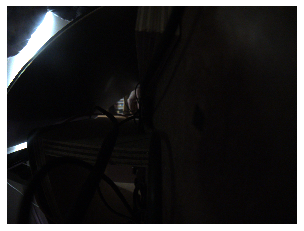

In [ ]:
try:
    cam.deinitialize()
except:
    pass
cam = Camera(model='ptgrey', identity='19312753', name='FrontLeft')
cam.register_event_handler()

# cam.register_event_handler()
cam.start()
img = cam.get_next_image()
show_img(img)
# cam.stop()

## Get and set properties

In [ ]:
cam.binning = 2
test_eq(cam.binning, 2)

cam.size_readout = 600
cam.setprops( {'OffsetX':200, 'OffsetY':200} )
test_eq(cam.size_max, (2000, 1500))
test_eq(cam.size_readout, (2000, 1500))

print(cam.gain_limit)
cam.gain_auto = True
test_eq(cam.gain_auto, True)
print(cam.exposure_time_auto)
print(cam.frame_rate_limit)

cam.frame_rate = 14
test_eq(int(cam.frame_rate), 14)

cam.frame_rate_auto = False
test_eq(cam.frame_rate_auto, False)

cam.setprops({'ExposureTime': 10})
cam.setprops({'ExposureAuto':'Off'} )
cam.exposure_time = 5
print(cam.exposure_time)
print(cam.exposure_time_limit)
print(cam.exposure_time_auto)

cam.setprops({'ExposureAuto':'Continuous'} )
cam.setprops({'ExposureAuto':'Off'} )
cam.exposure_time_auto = True
print(cam.getprops( ['BinningHorizontal','BinningVertical', 'ExposureTime', 'ExposureAuto' , 
                'OffsetX', 'OffsetY', 'Width', 'Height', 'WidthMax','HeightMax', 'AcquisitionFrameRateEnable']))

cam.start()
test_eq(cam.is_running, True)
print('cam.get_next_image().shape', cam.get_next_image().shape)

cam.stop()
test_eq(cam.is_running, False)

cam.setprops( {'OffsetX':10000, 'OffsetY':100} )

cam.binning = 1
test_eq(cam.binning, 1)

cam.frame_rate = 2
test_eq(round(cam.frame_rate), 2)

print(cam.getprops( ['BinningHorizontal','BinningVertical', 'ExposureTime', 'ExposureAuto' , 
                'OffsetX', 'OffsetY', 'Width', 'Height', 'WidthMax','HeightMax', 
                     'AcquisitionFrameRateEnable', 'AcquisitionFrameRate']))
# cam.frame_rate

2020-01-09 10:44:40,039 FrontLeft-WARNING-MainThread-setprops-(190) Node: "OffsetX",  value: "700" is out of range.
2020-01-09 10:44:40,041 FrontLeft-WARNING-MainThread-setprops-(190) Node: "OffsetX",  value: "200" is out of range.
2020-01-09 10:44:40,083 FrontLeft-WARNING-MainThread-setprops-(192) Not allowed to change Node: "ExposureTime" now - Try "stop=True".
2020-01-09 10:44:40,134 FrontLeft-INFO-MainThread-start-(704) Acquisition started, name: FrontLeft
2020-01-09 10:44:40,301 FrontLeft-INFO-MainThread-stop-(725) Acquisition stopped, name: FrontLeft
2020-01-09 10:44:40,303 FrontLeft-WARNING-MainThread-setprops-(190) Node: "OffsetX",  value: "10000" is out of range.


(0.0, 27.045663671679687)
True
(1.579970524069903, 14.332912977661524)
5.004
(0.01, 29999.999)
False
{'BinningHorizontal': 2, 'BinningVertical': 2, 'ExposureTime': 5004.0, 'ExposureAuto': 'continuous', 'OffsetX': 0, 'OffsetY': 0, 'Width': 2000, 'Height': 1500, 'WidthMax': 2000, 'HeightMax': 1500, 'AcquisitionFrameRateEnable': True}
cam.get_next_image().shape (1500, 2000, 3)
{'BinningHorizontal': 1, 'BinningVertical': 1, 'ExposureTime': 10182.0, 'ExposureAuto': 'continuous', 'OffsetX': 0, 'OffsetY': 0, 'Width': 4000, 'Height': 3000, 'WidthMax': 4000, 'HeightMax': 3000, 'AcquisitionFrameRateEnable': True, 'AcquisitionFrameRate': 1.9999936000204799}


In [ ]:
cam.frame_rate_limit

(1.579970524069903, 3.5833071321915826)

## Initialise and start camera, get and show 1 image

2020-01-09 10:44:43,978 FrontLeft-INFO-MainThread-initialize-(344) Camera successfully initialised
2020-01-09 10:44:43,979 FrontLeft-INFO-MainThread-__init__-(114) Camera instance created with name: FrontLeft.
2020-01-09 10:44:44,006 FrontLeft-INFO-MainThread-start-(704) Acquisition started, name: FrontLeft
2020-01-09 10:44:46,056 FrontLeft-INFO-MainThread-stop-(725) Acquisition stopped, name: FrontLeft


Binning 1
size_readout (4000, 3000)


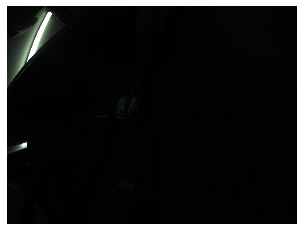

In [ ]:
import time
import os
import cv2

# Create instance and set parameters (will auto initialise)
try:
    cam.deinitialize()
except:
    pass
cam = Camera(model='ptgrey', identity='19312753', name='FrontLeft')
cam.debug_folder = os.getcwd()
cam.gain = 0 #decibel
cam.exposure_time_auto = True #milliseconds
cam.frame_rate_auto = True
cam.register_event_handler()
# Start acquisition
cam.start()
# Wait for a while
time.sleep(2)
# Read the latest image
img = cam.get_latest_image()

print('Binning', cam.binning)
print('size_readout', cam.size_readout)

# Stop the acquisition
cam.stop()
# Release the hardware
cam.deinitialize()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_img(img)

## Run in Open CV window for 100 frames

In [ ]:
from imutils.video import FPS
import imutils
import cv2
try:
    cam.deinitialize()
except:
    pass
cam = Camera(model='ptgrey', identity='19312753', name='FrontLeft')
cam.register_event_handler()

def show_FLIRcam(cam, width=1000, height=750):

    cam.start()
    fps = FPS().start()
    for i in range(100):
        img = cam.get_next_image()
        if img is not None:
            img = imutils.resize(img, width=width, height=height)     
            cv2.imshow('FLIR cam', img)
            if cv2.waitKey(10) == 27: 
                break  # esc to quit
            fps.update()              
    fps.stop()
    cam.stop()  
    cv2.destroyAllWindows()
    print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))
    
show_FLIRcam(cam)
cv2.destroyAllWindows()


2020-01-09 10:44:50,514 FrontLeft-INFO-MainThread-initialize-(344) Camera successfully initialised
2020-01-09 10:44:50,515 FrontLeft-INFO-MainThread-__init__-(114) Camera instance created with name: FrontLeft.
2020-01-09 10:44:50,523 FrontLeft-INFO-MainThread-start-(704) Acquisition started, name: FrontLeft
2020-01-09 10:44:53,692 FrontLeft-INFO-MainThread-stop-(725) Acquisition stopped, name: FrontLeft


[INFO] approx. FPS: 2.85


## Use a callback to print data from one camera
> Test start and stop under threading

In [ ]:
def callback(image, frameID, timestamp, camid):
    print(f'Cam1: image received, frame_ID: {frameID},  image.shape: {image.shape}, camid: {camid}')
    
try:
    cam.deinitialize()
except:
    pass

cam = Camera(model='ptgrey', identity='19312753', name='FrontLeft')

cam.binning = 1
cam.gain_auto = True
cam.frame_rate_auto = True
cam.add_event_callback(callback)
cam.register_event_handler() 

cam.start()

def startstop():
    for i in range(5):
        if not cam.is_running:
            print("Starting, count = ", i) 
            cam.start()
        sleep(1)
        print("Stoping, count = ", i)
        cam.stop()
        sleep(1)
        
thread = Thread(target=startstop, args=())
thread.start()
thread.join()

startstop()
cam.deinitialize()

2020-01-09 11:28:20,257 FrontLeft-INFO-MainThread-initialize-(344) Camera successfully initialised
2020-01-09 11:28:20,258 FrontLeft-INFO-MainThread-__init__-(114) Camera instance created with name: FrontLeft.
2020-01-09 11:28:20,314 FrontLeft-INFO-MainThread-start-(704) Acquisition started, name: FrontLeft
2020-01-09 11:28:21,340 FrontLeft-INFO-Thread-21-stop-(725) Acquisition stopped, name: FrontLeft
2020-01-09 11:28:22,349 FrontLeft-INFO-Thread-21-start-(704) Acquisition started, name: FrontLeft
2020-01-09 11:28:23,380 FrontLeft-INFO-Thread-21-stop-(725) Acquisition stopped, name: FrontLeft
2020-01-09 11:28:24,390 FrontLeft-INFO-Thread-21-start-(704) Acquisition started, name: FrontLeft
2020-01-09 11:28:25,417 FrontLeft-INFO-Thread-21-stop-(725) Acquisition stopped, name: FrontLeft
2020-01-09 11:28:26,428 FrontLeft-INFO-Thread-21-start-(704) Acquisition started, name: FrontLeft
2020-01-09 11:28:27,451 FrontLeft-INFO-Thread-21-stop-(725) Acquisition stopped, name: FrontLeft
2020-01-0

Cam1: image received, frame_ID: 0,  image.shape: (3000, 4000, 3), camid: 19312753
Cam1: image received, frame_ID: 1,  image.shape: (3000, 4000, 3), camid: 19312753
Stoping, count =  0
Starting, count =  1
Cam1: image received, frame_ID: 0,  image.shape: (3000, 4000, 3), camid: 19312753
Cam1: image received, frame_ID: 1,  image.shape: (3000, 4000, 3), camid: 19312753
Stoping, count =  1
Starting, count =  2
Cam1: image received, frame_ID: 0,  image.shape: (3000, 4000, 3), camid: 19312753
Cam1: image received, frame_ID: 1,  image.shape: (3000, 4000, 3), camid: 19312753
Stoping, count =  2
Starting, count =  3
Cam1: image received, frame_ID: 0,  image.shape: (3000, 4000, 3), camid: 19312753
Cam1: image received, frame_ID: 1,  image.shape: (3000, 4000, 3), camid: 19312753
Stoping, count =  3
Starting, count =  4
Cam1: image received, frame_ID: 0,  image.shape: (3000, 4000, 3), camid: 19312753
Cam1: image received, frame_ID: 1,  image.shape: (3000, 4000, 3), camid: 19312753
Stoping, count =

## Use a callback to print data from two cameras

In [ ]:
from imutils.video import FPS

def callback1(image, frameID, timestamp, camid):
    print(f'Cam1: image received, frame_ID: {frameID},  image.shape: {image.shape}, camid: {camid}')
    
def callback2(image, frameID, timestamp, camid):
    print(f'Cam2: image received, frame_ID: {frameID},  image.shape: {image.shape}, camid: {camid}')

try:
    cam1.deinitialize()
except:
    pass
try:
    cam2.deinitialize()
except:
    pass
try:
    cam.deinitialize()
except:
    pass
cam1 = Camera(model='ptgrey', identity='19312753', name='FrontLeft')
cam2 = Camera(model='ptgrey', identity='19312752', name='FrontRight')

cam1.binning = 2
cam1.gain_auto = True
cam1.frame_rate_auto = True
cam2.binning = 2
cam2.gain_auto = True
cam2.frame_rate_auto = True

def startstop():
    for i in range(5):
        print("Starting, count = ", i)
        cam1.register_event_handler()
        cam2.register_event_handler()
        
        cam1.add_event_callback(callback1)
        cam2.add_event_callback(callback2)
        
        
        cam1.start()
        cam2.start()
        sleep(1)
        
        print("Stoping, count = ", i)
    
        cam1.stop()
        cam2.stop()
        
        cam1.remove_event_callback(callback1)
        cam2.remove_event_callback(callback2)
        
        cam1.unregister_event_handler()
        cam2.unregister_event_handler()
        
startstop()        
thread = Thread(target=startstop, args=())

2020-01-09 10:47:16,605 FrontLeft-ERROR-MainThread-unregister_event_handler-(426) Failed to unregister event handler
Traceback (most recent call last):
  File "<ipython-input-5-354f8dc43358>", line 423, in unregister_event_handler
    self._ptgrey_camera.UnregisterEvent(self._ptgrey_event_handler)
  File "/home/john/.virtualenvs/Spinaker_Python3/lib/python3.6/site-packages/PySpin.py", line 48107, in UnregisterEvent
    return _PySpin._SWIG_CamPtr_UnregisterEvent(self, evtToUnregister)
_PySpin.SpinnakerException: Spinnaker: No Events are registered. [-1009]
2020-01-09 10:47:20,227 FrontLeft-INFO-MainThread-initialize-(344) Camera successfully initialised
2020-01-09 10:47:20,229 FrontLeft-INFO-MainThread-__init__-(114) Camera instance created with name: FrontLeft.
2020-01-09 10:47:20,230 FrontRight-INFO-MainThread-__init__-(75) New  console and file logging handlers added.
2020-01-09 10:47:21,544 FrontRight-INFO-MainThread-initialize-(344) Camera successfully initialised
2020-01-09 10:47

Starting, count =  0
Cam1: image received, frame_ID: 0,  image.shape: (1500, 2000, 3), camid: 19312753
Cam2: image received, frame_ID: 0,  image.shape: (1500, 2000, 3), camid: 19312752
Cam1: image received, frame_ID: 1,  image.shape: (1500, 2000, 3), camid: 19312753
Cam2: image received, frame_ID: 1,  image.shape: (1500, 2000, 3), camid: 19312752
Cam1: image received, frame_ID: 2,  image.shape: (1500, 2000, 3), camid: 19312753
Cam2: image received, frame_ID: 2,  image.shape: (1500, 2000, 3), camid: 19312752
Cam1: image received, frame_ID: 3,  image.shape: (1500, 2000, 3), camid: 19312753
Cam2: image received, frame_ID: 3,  image.shape: (1500, 2000, 3), camid: 19312752
Cam1: image received, frame_ID: 4,  image.shape: (1500, 2000, 3), camid: 19312753
Cam2: image received, frame_ID: 4,  image.shape: (1500, 2000, 3), camid: 19312752
Cam1: image received, frame_ID: 5,  image.shape: (1500, 2000, 3), camid: 19312753
Cam2: image received, frame_ID: 5,  image.shape: (1500, 2000, 3), camid: 1931

In [ ]:
if 0:
    import imutils
    import time
    import cv2
    
    import threading 
    class RunCam:
        width=1000
        height=750
        def __init__(self):
            self.stopped = False
            self.thread = Thread(target=self.update, args=())
            self.thread.daemon = True
            
        def update(self):
            while True:
                if self.stopped:
                    cv2.destroyAllWindows()
                    break
                img = cam.get_latest_image()
                # show_img(img)
                img = imutils.resize(img, width=1000, height=750)     
                cv2.imshow('FLIR cam', img)
                if cv2.waitKey(10) == 27: 
                    self.stop()  # esc to quit
        
        def start(self):
            self.thread.start()
            return self
        
        def stop(self):
            """indicate that the thread should be stopped"""
            self.stopped = True
            # wait until stream resources are released (producer thread might be still grabbing frame)
            self.thread.join() 
            
            
    x = RunCam()
    
    # x.start()
    # x.stop()